In [26]:
# Same model as last notebook, but just following best practices:
#   - minibatch gradient descent
#   - ad-hoc learning rate tuning
#   - learning rate decay
#   - train/validation/test data split
#   - better hyperparameter settings (hidden layer size, embedding size, etc.)
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.set_default_device("mps")

In [27]:
# build the vocabulary of characters and mappings to/from integer ids
words = open('res/names.txt', 'r').read().split()
chars = sorted(list(set(''.join(words))))  # tokens a-z

stoi = {s:i+1 for i,s in enumerate(chars)}  # map each token to unique id
stoi['.'] = 0  # add encoding for terminating token

itos = {i:s for s,i in stoi.items()}  # create the reverse mapping
print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [28]:
# define hyperparameters we'll use later
batch_size = 512  # batch size: how many samples are in our batches?
vocab_size = 27   # vocabulary size: how big is our vocabulary of tokens?
ngram_len = 3     # context length: how many characters do we take to predict the next one?
embed_dim = 2     # embedding dimension: what is the length of the embedding vector for each token?
hidden_dim = 256  # how many neurons are in the hidden layer of the MLP?

In [29]:
# build the dataset
#   - split into 80% train, 10% validation, and 10% test
def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * ngram_len
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [30]:
# create the layers of the model
C = torch.randn((vocab_size, embed_dim), requires_grad=True)
W1 = torch.randn((ngram_len * embed_dim, hidden_dim), requires_grad=True)
b1 = torch.randn(hidden_dim, requires_grad=True)
W2 = torch.randn((hidden_dim, vocab_size), requires_grad=True)
b2 = torch.randn(vocab_size, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

# define a forward pass for the model
def forward(xs):
    # embedding
    emb = C[xs]
    # hidden layer
    flat_emb = emb.view(emb.shape[0], -1)
    h = torch.tanh(flat_emb @ W1 + b1)
    # output layer
    return h @ W2 + b2

print("Parameters:", sum(p.nelement() for p in parameters))

Parameters: 8785


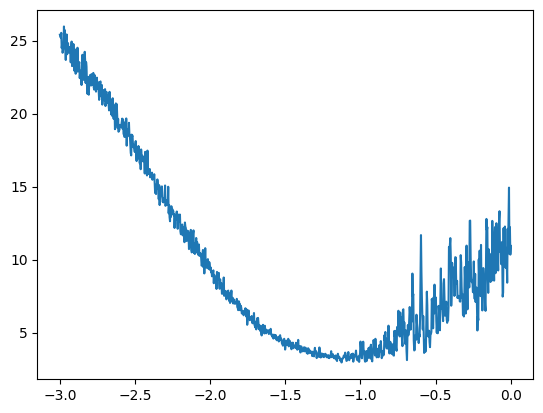

In [31]:
# find a good learning rate - by trying a bunch of them on the validation set
lre = torch.linspace(-3, 0, 1000)  # range [-3, 0] with 1000 steps
lrs = 10**lre  # map range [-3, 0] -> [0.001, 1]

lri = []
lossi = []

for epoch in range(1000):
    # minibatch construct
    ix = torch.randint(0, Xdev.shape[0], (batch_size, ))
    # forward pass
    logits = forward(Xdev[ix])
    loss = F.cross_entropy(logits, Ydev[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[epoch]  # try different learning rate for each epoch in smooth range [0.001, 1]
    for p in parameters:
        p.data -= lr * p.grad
    # track stats on learning rate
    lri.append(lre[epoch].item())
    lossi.append(loss.item())

# plot the stats on the learning rate
plt.plot(lri, lossi)

# We want to pick a learning rate that isn't too slow and isn't too unstable.
#
# In the graph of loss vs lr, the range of good lrs is represented by the valley of
# the curve. To the left of the valley, lrs are too slow. to the right, lrs are too
# unstable.
# In this case, a lr around the range [-1.5, -0.5] (roughly corresponding to a learning
# rate in the range [0.032, 0.32]) seems reasonable. I choose a learning rate of 0.1.
#
# If you really want to squeeze out the last ounce of performance, you can use a smaller
# rate to further train the model after you've trained the model with this learning rate.
# But at some point you're just splitting hairs...

Epoch 0: Loss= 12.11007308959961
Epoch 1000: Loss= 2.684894323348999
Epoch 2000: Loss= 2.66245698928833
Epoch 3000: Loss= 2.5742735862731934
Epoch 4000: Loss= 2.5686087608337402
Epoch 5000: Loss= 2.559614658355713
Epoch 6000: Loss= 2.512064218521118
Epoch 7000: Loss= 2.486872434616089
Epoch 8000: Loss= 2.4901442527770996
Epoch 9000: Loss= 2.425565719604492
Epoch 10000: Loss= 2.516047954559326
Epoch 11000: Loss= 2.461242437362671
Epoch 12000: Loss= 2.470811367034912
Epoch 13000: Loss= 2.4736990928649902
Epoch 14000: Loss= 2.498534679412842
Epoch 15000: Loss= 2.4908571243286133
Epoch 16000: Loss= 2.436246633529663
Epoch 17000: Loss= 2.414273977279663
Epoch 18000: Loss= 2.529949903488159
Epoch 19000: Loss= 2.444110870361328
Epoch 20000: Loss= 2.3872218132019043
Epoch 21000: Loss= 2.4728646278381348
Epoch 22000: Loss= 2.4405863285064697
Epoch 23000: Loss= 2.436152935028076
Epoch 24000: Loss= 2.4015684127807617
Epoch 25000: Loss= 2.3319342136383057
Epoch 26000: Loss= 2.3045597076416016
Epoc

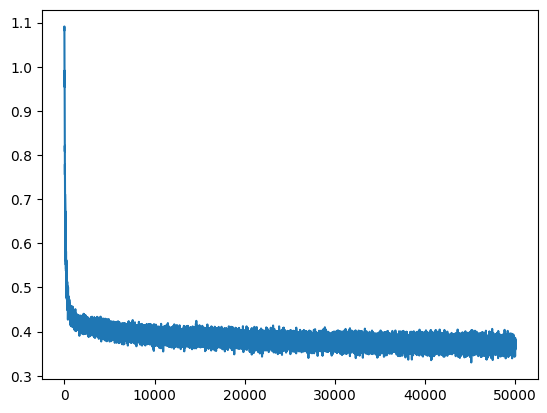

In [32]:
# train the model - minibatch gradient descent
epochi = []
lossi = []
epochs = 50000
for epoch in range(epochs):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    # forward pass
    logits = forward(Xtr[ix])
    loss = F.cross_entropy(logits, Ytr[ix])
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}: Loss= {loss.item()}')
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        progress = (epochs - epoch) / epochs
        p.data -= (0.1 - (0.1 - 0.01) * progress) * p.grad  # dynamic learning rate
        # p.data -= 0.1 * p.grad  # learning rate decay
        # p.data -= 0.5 * p.grad  # learning rate decay
        # p.data -= 0.01 * p.grad  # learning rate decay
    # track stats
    epochi.append(epoch)
    lossi.append(loss.log10().item())

print()

logits = forward(Xtr)
loss = F.cross_entropy(logits, Ytr)
print(f'Training Loss= {loss.item()}')

logits = forward(Xte)
loss = F.cross_entropy(logits, Yte)
print(f'Test Loss= {loss.item()}')

plt.plot(epochi, lossi)

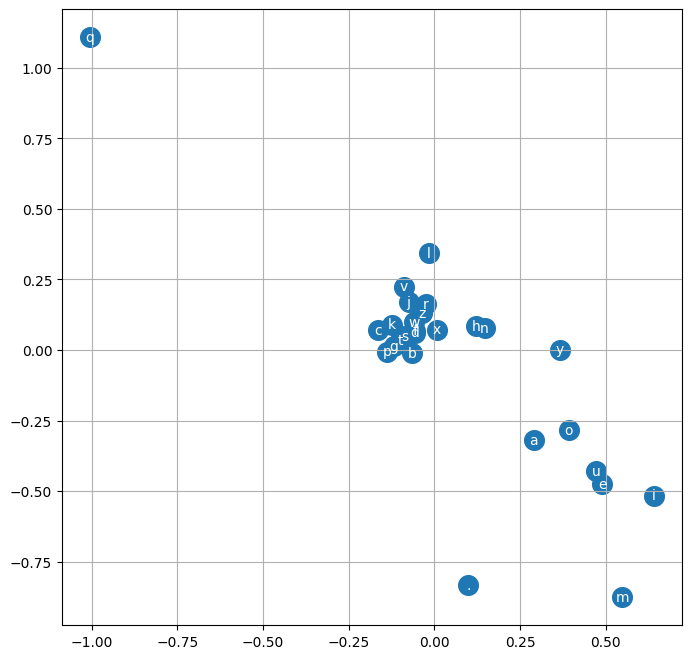

In [56]:
# visualize the 2D embedding space C for all token.
#   - notice that some of the tokens are tightly clustered.
#   - others like '.', 'm', and especially 'q' are considered more "special".
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].detach().cpu(), C[:, 1].detach().cpu(), s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [69]:
# let's train a new model from scratch but with better hyperparameters
#   - bigger batch size
#   - bigger hidden layer
#   - increase context to 4-gram
#   - increase embed space to 12 dimensions
batch_size = 1024 # batch size: how many samples are in our batches?
vocab_size = 27   # vocabulary size: how big is our vocabulary of tokens?
ngram_len = 4     # context length: how many characters do we take to predict the next one?
embed_dim = 12    # embedding dimension: what is the length of the embedding vector for each token?
hidden_dim = 512  # how many neurons are in the hidden layer of the MLP?

# build the dataset
#   - split into 80% train, 10% validation, and 10% test
def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * ngram_len
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# create the layers of the model
C = torch.randn((vocab_size, embed_dim), requires_grad=True)
W1 = torch.randn((ngram_len * embed_dim, hidden_dim), requires_grad=True)
b1 = torch.randn(hidden_dim, requires_grad=True)
W2 = torch.randn((hidden_dim, vocab_size), requires_grad=True)
b2 = torch.randn(vocab_size, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

# define a forward pass for the model
def forward(xs):
    # embedding
    emb = C[xs]
    # hidden layer
    flat_emb = emb.view(emb.shape[0], -1)
    h = torch.tanh(flat_emb @ W1 + b1)
    # output layer
    return h @ W2 + b2

print("Parameters:", sum(p.nelement() for p in parameters))

Parameters: 39263


Epoch 0: Loss= 2.1557228565216064
Epoch 1000: Loss= 2.156621217727661
Epoch 2000: Loss= 2.153348445892334
Epoch 3000: Loss= 2.142200469970703
Epoch 4000: Loss= 2.1404640674591064
Epoch 5000: Loss= 2.1517648696899414
Epoch 6000: Loss= 2.1330158710479736
Epoch 7000: Loss= 2.1456246376037598
Epoch 8000: Loss= 2.1449756622314453
Epoch 9000: Loss= 2.15216064453125

Training Loss= 2.1479544639587402
Test Loss= 2.2065629959106445


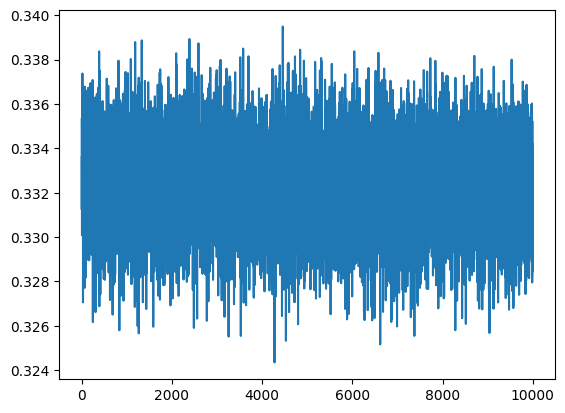

In [107]:
epochi = []
lossi = []
epochs = 10000
batch_size = 1024
for epoch in range(epochs):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    # forward pass
    logits = forward(Xtr[ix])
    loss = F.cross_entropy(logits, Ytr[ix])
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}: Loss= {loss.item()}')
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        progress = (epochs - epoch) / epochs
        # p.data -= 0.1 * p.grad  # learning rate decay
        p.data -= 0.01 * p.grad  # learning rate decay
        # p.data -= 0.001 * p.grad  # learning rate decay
    # track stats
    epochi.append(epoch)
    lossi.append(loss.log10().item())

print()

logits = forward(Xtr)
loss = F.cross_entropy(logits, Ytr)
print(f'Training Loss = {loss.item()}')

logits = forward(Xte)
loss = F.cross_entropy(logits, Yte)
print(f'Test Loss = {loss.item()}')

plt.plot(epochi, lossi)

In [109]:
# lets generate some sample names!
for _ in range(10):
    out = []
    context = [0] * ngram_len  # initialize with all '.'
    while True:
        logits = forward(torch.tensor([context]))  # feed context through model to get logits
        probs = F.softmax(logits, dim=1)  # convert output logits to probability distribution
        ix = torch.multinomial(probs, num_samples=1).item()  # sample the next token from this distribution

        context = context[1:] + [ix]  # shift and append the next token to the context
        out.append(ix)  # aggregate the name tokens
        if ix == 0:  # on generate '.', terminate
            break

    print(''.join(itos[i] for i in out))

obkliyah.
jaelanch.
fram.
jailynn.
vevika.
wenycy.
kengdin.
anika.
avan.
emmalecen.
